![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 10 -  Object Detection </center>
### <center> Vanilla Object Detection </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/10_ObjectDetection/MainVanillaObjectDetection.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/10_ObjectDetection/DeepLearningFramework ./DeepLearningFramework
    !pip install torchinfo

In [4]:
#-----------------------------------------------------------#
#-----------------------------------------------------------#
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn    as nn
import torch.optim as optim
import torchinfo

from torch.optim.lr_scheduler import OneCycleLR
#-----------------------------------------------------------#
#-----------------------------------------------------------#
torch.set_printoptions(3, linewidth=120, sci_mode=False)
torch.backends.cudnn.benchmark = True

#### Constants:

In [5]:
IMAGE_SIZE = 100
GRID_SIZE  = 5
LABELS     = ['R', 'G', 'B']

DEVICE     = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#### `CreateImage` creates a synthetic image for object detection:

In [6]:
from DeepLearningFramework.VanillaObjectDetectionUtils import CreateImage
        
mI, mBBox = CreateImage(IMAGE_SIZE, 3)
mBBox

tensor([[1.000, 2.000, 0.649, 0.644, 0.083, 0.712],
        [1.000, 0.000, 0.224, 0.811, 0.304, 0.379],
        [1.000, 2.000, 0.331, 0.650, 0.661, 0.639]])

#### Plot an image with its bounding boxes:

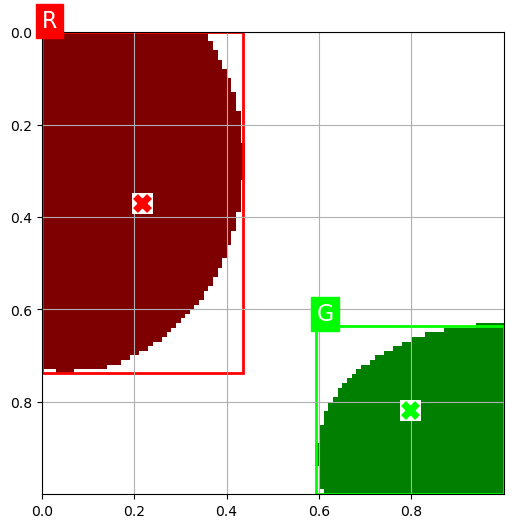

In [7]:
from DeepLearningFramework.VanillaObjectDetectionUtils import PlotImage

nObjects  = np.random.randint(5) + 1
mI, mBBox = CreateImage(IMAGE_SIZE, nObjects)

PlotImage(mI, mBBox, LABELS, lColors=np.eye(3), gridSize=GRID_SIZE)
plt.show ()

#### Create synthetic datasets:
Note that `mBBox.shape = (Di, 6)` where `Di` is the number of objects.  
`Di` is different from image to image.

In [8]:
def MakeData(N):
    mX    = torch.empty(N, 3, IMAGE_SIZE, IMAGE_SIZE)
    lBBox = [None] * N
    for ii in range(N):
        nObjects   = np.random.randint(3) + 1
        mXi, mBBox = CreateImage(IMAGE_SIZE, nObjects)
        mX   [ii]  = mXi
        lBBox[ii]  = mBBox

    return mX, lBBox
        
nTrain = 10000
nTest  = 1000

mTrainX, lTrainBBox = MakeData(nTrain)
mTestX,  lTestBBox  = MakeData(nTest)

mTrainX.shape, len(lTrainBBox)

(torch.Size([10000, 3, 100, 100]), 10000)

### `BBox2Target`
This function transforms BBoxes into targets.  
The targets are compared with the network output.

In [9]:
def BBox2Target(mBBox, gridSize):
    '''
    * Input:
        - mBBox .shape = (D, 6)
        - mBBox [ii,:] = [prob | cIdx | x, y, W, H]
    * Output:
        - mTarget.shape    = (6, S, S)
        - mTarget[:,ii,jj] = [prob | x, y, W, H | cIdx]
    '''
    D        = mBBox.shape[0]
    S        = gridSize
    mProb    = torch.zeros(1, S, S)
    mLabel   = torch.zeros(1, S, S)
    mBBoxOut = torch.zeros(4, S, S)
    
    if D > 0:
        vP, vIdx        = mBBox[:,:2].T
        mXYWH           = mBBox[:,2:] * gridSize
        vX, vY, vW ,vH  = mXYWH.T
        vCx             = vX.floor().long() #-- cell x index
        vCy             = vY.floor().long() #-- cell y index
        vX             -= vCx               #-- cell x
        vY             -= vCy               #-- cell y

        mProb   [0,vCy,vCx] = vP
        mLabel  [0,vCy,vCx] = vIdx
        mBBoxOut[:,vCy,vCx] = torch.stack([vX, vY, vW, vH])
    
    mTarget = torch.cat([mProb, mBBoxOut, mLabel])
        
    return mTarget

mBBox   = lTrainBBox[0]
mTarget = BBox2Target(mBBox, GRID_SIZE)
mTarget.shape

torch.Size([6, 5, 5])

### Define a `Dataset` class
Since the number of targets is different in each image we use a `list` and not a `tensor`.

In [10]:
if False:
    class VanillaObjectDataset(torch.utils.data.Dataset):
        def __init__(self, mX, lBBox, gridSize):
            #-- mX       .shape = (N, C, W, H)
            #-- len(lBBox)      =  N
            #-- lBBox[ii].shape = (Di, 6)
            self.mX       = mX
            self.lBBox    = lBBox
            self.gridSize = gridSize

        def __len__(self):
            return self.mX.shape[0]

        def __getitem__(self, idx):
            mXi     = self.mX   [idx]
            mBBox   = self.lBBox[idx]
            mTarget = BBox2Target(mBBox, self.gridSize)
            return mXi, mBBox, mTarget

#### Create train and test sets:

In [11]:
from DeepLearningFramework.VanillaObjectDetectionUtils import VanillaObjectDataset

oTrainSet = VanillaObjectDataset(mTrainX, lTrainBBox, GRID_SIZE)
oTestSet  = VanillaObjectDataset(mTestX,  lTestBBox,  GRID_SIZE)

len(oTrainSet), len(oTestSet)

(10000, 1000)

#### Test our dataset code:
`mTarget.shape    = (6, 5, 5)`  
`mTarget[:,ii,jj] = [prob, cIdx, x, y, W, H]`

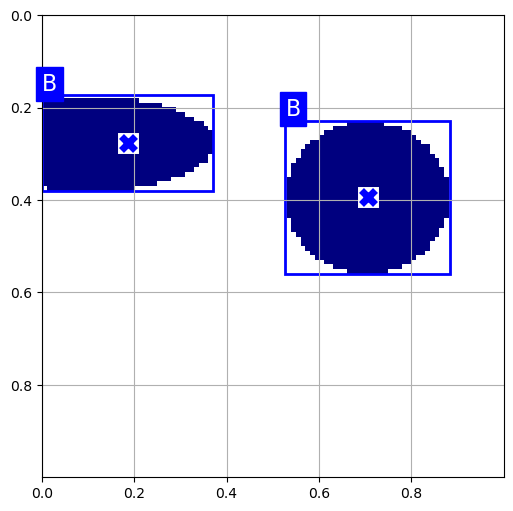

tensor([[0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [12]:
idx                = np.random.randint(nTrain)
mX, mBBox, mTarget = oTrainSet[idx]

PlotImage(mX, mBBox, vLabels=LABELS, lColors=np.eye(3))
plt.show()
mTarget[0,:,:]

#### Create a `DataLoader` with its `Collate` function:

In [13]:
if False:
    def VanillaObjectCollate(lBatch):

        lX, lBBox, lTarget = zip(*lBatch)
        mX                 = torch.stack(lX)
        mTarget            = torch.stack(lTarget)

        return mX, lBBox, mTarget

In [14]:
from DeepLearningFramework.Dataset import VanillaObjectCollate

batchSize = 256
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=1*batchSize, collate_fn=VanillaObjectCollate, num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, collate_fn=VanillaObjectCollate, num_workers=2, persistent_workers=True)

mX,       lBBox,      mTarget = next(iter(oTrainDL))
mX.shape, len(lBBox), mTarget.shape

(torch.Size([256, 3, 100, 100]), 256, torch.Size([256, 6, 5, 5]))

#### A simple test:

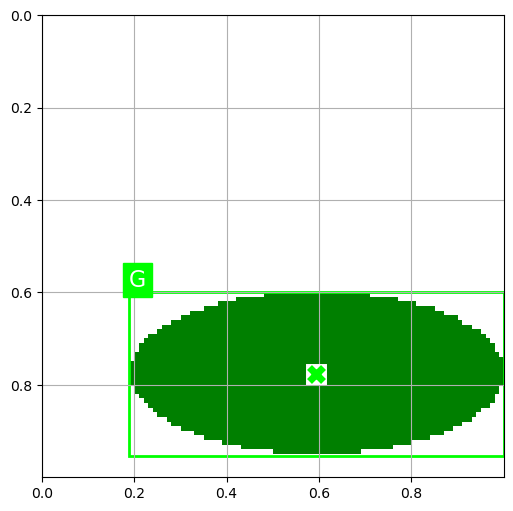

In [15]:
mX, lBBox, mTarget = next(iter(oTrainDL))

PlotImage(mX[0], lBBox[0], vLabels=LABELS, lColors=np.eye(3))

### Define the model:
The output shape is: $(5+L) \times S \times S$.  
In our case $S = 5$ and $L = 3$.  
($L$ is the number of labels)

In [16]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.oNN = nn.Sequential(
            nn.Identity(),
            nn.Conv2d(3,   8,   5, stride=2, padding=2, bias=False), nn.BatchNorm2d(8  ), nn.ReLU(), nn.Dropout2d(0.1),
            nn.Conv2d(8,   16,  3, stride=1, padding=1, bias=False), nn.BatchNorm2d(16 ), nn.ReLU(), nn.Dropout2d(0.1),
            nn.Conv2d(16,  32,  3, stride=1, padding=1, bias=False), nn.BatchNorm2d(32 ), nn.ReLU(), nn.Dropout2d(0.1),
            nn.Conv2d(32,  64,  3, stride=2, padding=1, bias=False), nn.BatchNorm2d(64 ), nn.ReLU(), nn.Dropout2d(0.1),
            nn.Conv2d(64,  64,  3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64 ), nn.ReLU(), nn.Dropout2d(0.1),
            nn.Conv2d(64,  64,  3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64 ), nn.ReLU(), nn.Dropout2d(0.1),
            nn.Conv2d(64,  64,  3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64 ), nn.ReLU(), nn.Dropout2d(0.1),
            nn.Conv2d(64,  64,  3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64 ), nn.ReLU(), nn.Dropout2d(0.1),
            nn.Conv2d(64,  64,  3, stride=2, padding=1, bias=False), nn.BatchNorm2d(64 ), nn.ReLU(), nn.Dropout2d(0.1),
            nn.Conv2d(64,  64,  3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64 ), nn.ReLU(), nn.Dropout2d(0.1),
            nn.Conv2d(64,  64,  3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64 ), nn.ReLU(), nn.Dropout2d(0.1),
            nn.Conv2d(64,  64,  3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64 ), nn.ReLU(), nn.Dropout2d(0.1),
            nn.Conv2d(64,  128, 3, stride=2, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(), nn.Dropout2d(0.1),
            nn.Conv2d(128, 256, 3, stride=1, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(), nn.Dropout2d(0.1),
            nn.Conv2d(256, 512, 3, stride=1, padding=0, bias=False), nn.BatchNorm2d(512), nn.ReLU(), nn.Dropout2d(0.1),
            nn.Conv2d(512, 8,   1, stride=1, padding=0, bias=True ),
    )
        
    def forward(self, mX):
        mTarget = self.oNN(mX)        #-- mTarget.shape = (N, 8, S, S)
        mTarget[:,1:3,:,:].sigmoid_() #-- makes sure x and y are in [0, 1] 
                
        return mTarget
#-------------------------------------------------------------------------------------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------------#
#-- Model summary:
mTarget = Model()(mX)

mTarget.shape, \
torchinfo.summary(Model(), mX.shape)

(torch.Size([256, 8, 5, 5]),
 Layer (type:depth-idx)                   Output Shape              Param #
 Model                                    --                        --
 ├─Sequential: 1-1                        [256, 8, 5, 5]            --
 │    └─Identity: 2-1                     [256, 3, 100, 100]        --
 │    └─Conv2d: 2-2                       [256, 8, 50, 50]          600
 │    └─BatchNorm2d: 2-3                  [256, 8, 50, 50]          16
 │    └─ReLU: 2-4                         [256, 8, 50, 50]          --
 │    └─Dropout2d: 2-5                    [256, 8, 50, 50]          --
 │    └─Conv2d: 2-6                       [256, 16, 50, 50]         1,152
 │    └─BatchNorm2d: 2-7                  [256, 16, 50, 50]         32
 │    └─ReLU: 2-8                         [256, 16, 50, 50]         --
 │    └─Dropout2d: 2-9                    [256, 16, 50, 50]         --
 │    └─Conv2d: 2-10                      [256, 32, 50, 50]         4,608
 │    └─BatchNorm2d: 2-11           

### Loss function (BCE + MSE + CE):
$$\ell\left(\hat{\boldsymbol{y}},\boldsymbol{y}\right)=\begin{cases}
\lambda_{\text{BCE}}\cdot\ell_{\text{BCE}}\left(\hat{y}_{\text{detect}},y_{\text{detect}}\right) & y_{\text{detect}}=0\\
\lambda_{\text{BCE}}\cdot\ell_{\text{BCE}}\left(\hat{y}_{\text{detect}},y_{\text{detect}}\right)+\lambda_{\text{MSE}}\cdot\ell_{\text{MSE}}\left(\hat{\boldsymbol{y}}_{\text{bbox}},\boldsymbol{y}_{\text{bbox}}\right)+\lambda_{\text{CE}}\cdot\ell_{\text{CE}}\left(\hat{\boldsymbol{y}}_{\text{label}},\boldsymbol{y}_{\text{label}}\right) & y_{\text{detect}}=1
\end{cases}$$
where $\lambda_{\text{BCE}}\lambda_{\text{BCE}}, \lambda_{\text{MSE}}$ and $\lambda_{\text{CE}}$ are the weights
of each loss.

In [17]:
def Loss(mOutput, mTarget):
    #-- mOutput.shape       = (N, 8, 5, 5)
    #-- mTarget.shape       = (N, 6, 5, 5)
    #-- mOutput[ii,:,jj,kk] = [p | x, y, W, H | R, G, B]
    #-- mTarget[ii,:,jj,kk] = [p | x, y, W, H | cIdx]
    mProb      = mTarget[:,0,:,:]
    mMask      = mProb == 1
    
    mXYWH      = mTarget[:,1:5,:,:].permute(0,2,3,1)[mMask] #-- mXYWH .shape = (T, 4)
    vLabel     = mTarget[:,5  ,:,:].long()          [mMask] #-- vLabel.shape = (T)
    
    mProbPred  = mOutput[:,0,  :,:] 
    mXYWHPred  = mOutput[:,1:5,:,:].permute(0,2,3,1)[mMask] #-- mXYWHPred .shape = (T, 4)
    mLabelPred = mOutput[:,5:, :,:].permute(0,2,3,1)[mMask] #-- mLabelPred.shape = (T, L)
    
    BCE = nn.BCEWithLogitsLoss()(mProbPred,  mProb)
    MSE = nn.MSELoss          ()(mXYWHPred,  mXYWH)
    CE  = nn.CrossEntropyLoss ()(mLabelPred, vLabel)
    
    loss = BCE + MSE + CE
    
    return loss, BCE.item(), CE.item(), MSE.item()

### `Epoch`
Since we have not implemented a metric (yet), we will use: `metric = -loss`

In [18]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    vEpochStats = np.zeros(5) #-- (Loss, BCE, CE, MSE, -Loss)
    count       = 0
    nIter       = len(oDataDL)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU

    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (mX, _, mTarget) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX      = mX     .to(DEVICE)
        mTarget = mTarget.to(DEVICE)

        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mOut               = oModel(mX)
            loss, BCE, CE, MSE = Loss  (mOut, mTarget)

            #-- Backward:
            oOptim    .zero_grad() #-- set gradients to zeros
            loss      .backward () #-- backward
            oOptim    .step     () #-- update parameters
            oScheduler.step     () #-- update learning rate
            
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mOut               = oModel(mX)
                loss, BCE, CE, MSE = Loss  (mOut, mTarget)        

        with torch.no_grad():
            Nb           = mX.shape[0]
            vIterStats   = np.array([loss.item(), BCE, CE, MSE, -loss.item()])
            vEpochStats += Nb * vIterStats
            count       += Nb
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    vEpochStats /= count

    return vEpochStats

In [19]:
import time

def TrainModel(oModel, oTrainData, oValData, Loss, Metric, nEpochs, oOptim, oScheduler=None, sModelName='VanillaObjectDetection'):

    TRAIN        = 0
    VAL          = 1
    vLR          = np.full(0,       np.nan)
    mHistory     = np.full((2, 5, nEpochs), np.nan)
    lNames       = ['Loss', 'BCE', 'CE', 'MSE', 'Metric']
    bestMetric   = -float('inf')

    fig, _ = plt.subplots(2, 2, figsize=(12, 6))
    for epoch in range(nEpochs):
        startTime               = time.time()
        mHistory[TRAIN,:,epoch] = Epoch(oModel, oTrainData, Loss, Metric, oOptim, oScheduler, bTrain=True ) #-- train
        mHistory[VAL,  :,epoch] = Epoch(oModel, oValData,   Loss, Metric,                     bTrain=False) #-- validate
        epochTime               = time.time() - startTime

        #-- Display:
        if epoch % 10 == 0:
            print('-' * 120)
        print('Epoch '            f'{epoch                   :03d}:',   end='')
        print(' | Train loss: '   f'{mHistory[TRAIN,0,epoch] :6.3f}',   end='')
        print(' | Val loss: '     f'{mHistory[VAL,  0,epoch] :6.3f}',   end='')
        print(' | Train Metric: ' f'{mHistory[TRAIN,4,epoch] :6.3f}',   end='')
        print(' | Val Metric: '   f'{mHistory[VAL,  4,epoch] :6.3f}',   end='')
        print(' | epoch time: '   f'{epochTime               :6.3f} |', end='')

        valMetric = mHistory[VAL,4,epoch]
        #-- Save best model (early stopping):
        if valMetric > bestMetric:
            bestMetric = valMetric
            try   : torch.save(oModel.state_dict(), sModelName + '.pt')
            except: pass
            print(' <-- Checkpoint!')
        else:
            print('')
            
        for ii, ax in enumerate(fig.axes):
            ax.cla      ()
            ax.plot     (mHistory[TRAIN, ii], 'b', label='Train')
            ax.plot     (mHistory[VAL,   ii], 'r', label='Validation')
            ax.set_title(lNames[ii])
            ax.grid     ()
            ax.legend   ()

        fig.canvas.draw ()
        plt.tight_layout()
        plt.pause       (1e-4)

    #-- Load best model (early stopping):
    oModel.load_state_dict(torch.load(sModelName + '.pt'))

    return mHistory

In [20]:
Metric = None #-- We will do this later

<IPython.core.display.Javascript object>


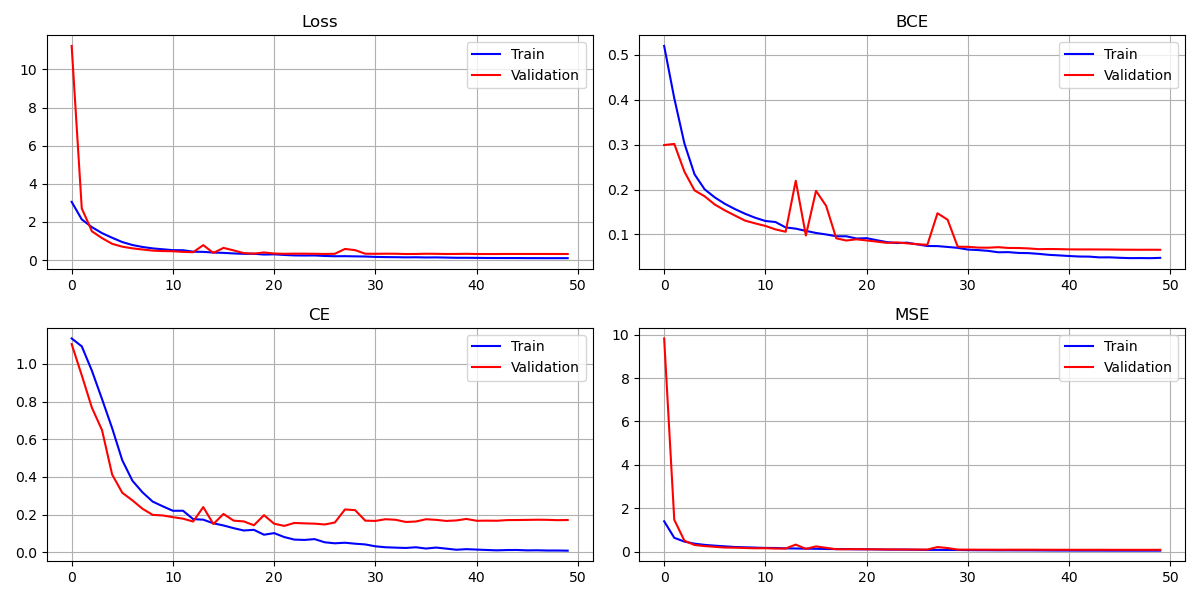

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  3.054 | Val loss: 11.228 | Train Metric: -3.054 | Val Metric: -11.228 | epoch time:  8.018 | <-- Checkpoint!
Epoch 001: | Train loss:  2.133 | Val loss:  2.709 | Train Metric: -2.133 | Val Metric: -2.709 | epoch time:  3.406 | <-- Checkpoint!
Epoch 002: | Train loss:  1.728 | Val loss:  1.511 | Train Metric: -1.728 | Val Metric: -1.511 | epoch time:  3.426 | <-- Checkpoint!
Epoch 003: | Train loss:  1.414 | Val loss:  1.152 | Train Metric: -1.414 | Val Metric: -1.152 | epoch time:  3.395 | <-- Checkpoint!
Epoch 004: | Train loss:  1.171 | Val loss:  0.853 | Train Metric: -1.171 | Val Metric: -0.853 | epoch time:  3.389 | <-- Checkpoint!
Epoch 005: | Train loss:  0.946 | Val loss:  0.704 | Train Metric: -0.946 | Val Metric: -0.704 | epoch time:  3.422 | <-- Checkpoint!
Epoch 006: | Train loss:  0.792 | Val loss:  0.617 | Train Metric: -0.792 

In [21]:
%matplotlib notebook

nEpochs    = 50
nIter      = nEpochs * len(oTrainDL)

oModel     = Model      ().to(DEVICE)
oOptim     = optim.AdamW(oModel.parameters(), lr=0, betas=(0.9, 0.99), weight_decay=1e-3)
oScheduler = OneCycleLR (oOptim, max_lr=1e-3, total_steps=nIter)
lHistory   = TrainModel (oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler)

In [ ]:
# oModel.load_state_dict(torch.load('VanillaObjectDetection_v1.pt'))
# oModel.train(False);

#### Output to target:
* Apply `sigmoid` on detection probability.  
* Apply `argmax` on classification.

In [22]:
def Output2Target(mOutput):
    #-- mOutput.shape       = (N, 8, 5, 5)
    #-- mOutput[ii,:,jj,kk] = [p | x, y, W, H | R, G, B]
    mProb   = torch.sigmoid(mOutput[:,[0],:,:])
    mXYWH   =               mOutput[:,1:5,:,:]
    mLabel  = torch.argmax (mOutput[:,5:, :,:], dim=1, keepdims=True)
    
    mTarget = torch.cat([mProb, mXYWH, mLabel], dim=1)
    return mTarget

#### Target to BBox:
* Transform each cell in the target grid ($S \times S$) into a BBox.
* Scale back the XYWH position of the BBox

In [23]:
def Target2BBox(mTarget):
    '''
    * Input:
        - mTarget.shape       = (N, 6, S, S)
        - mTarget[ii,:,jj,kk] = [p | x, y, W, H | cIdx]
    * Output:
        - mBBox.shape = (N, S*S, 6)
    '''
    v       = torch.arange(GRID_SIZE, device=mTarget.device)
    XX, YY  = torch.meshgrid(v, v, indexing='xy')
    
    mProb  = mTarget[:,[0],:,:]
    mXYWH  = mTarget[:,1:5,:,:].clone()
    mLabel = mTarget[:,[5],:,:]
    
    mXYWH[:,0,:,:] += XX[None,:,:]
    mXYWH[:,1,:,:] += YY[None,:,:]
    mXYWH          /= GRID_SIZE
    
    mBBox = torch.cat([mProb, mLabel, mXYWH], dim=1)            #-- mBBox.shape = (N, 6,  5, 5)
    mBBox = mBBox.permute(0,2,3,1).reshape(-1, GRID_SIZE**2, 6) #-- mBBox.shape = (N, 25, 6)
        
    return mBBox

#### Test model:

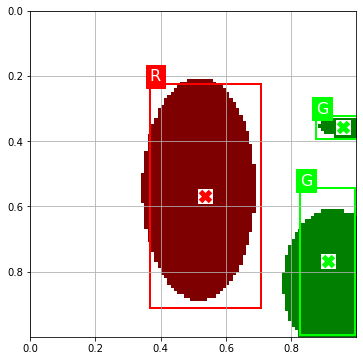

In [35]:
%matplotlib inline

mXi, mBBox, mTarget = oTestSet[np.random.randint(nTest)]
with torch.no_grad():
    mOutput = oModel(mXi[None].to(DEVICE))

mTargetPred = Output2Target(mOutput)
mBBoxPred   = Target2BBox  (mTargetPred).cpu()[0]
vIdx        = mBBoxPred[:,0] > 0.5 #-- take only prediciton with prob > 0.5

PlotImage(mXi, mBBoxPred[vIdx], vLabels=LABELS, lColors=np.eye(3), gridSize=GRID_SIZE)
plt.show ()